# This script describes how to run ACCESS-OM2 1-degree simulations with perturbed forcing.

The perturbed forcing system is implemented in YATM, and described at https://github.com/COSIMA/access-om2/wiki/Tutorials#Scaling-the-forcing-fields.

Also note that there are several issues linked at the bottom of that post that may also be useful:
- https://github.com/COSIMA/libaccessom2/issues/30
- https://github.com/COSIMA/libaccessom2/issues/31

Note that the two configurations that I've used below to create these forcing perturbations are located on github at:
- https://github.com/rmholmes/1deg_jra55_iaf/tree/forcing_perturb_tutorial_control
- https://github.com/rmholmes/1deg_jra55_iaf/tree/forcing_perturb_tutorial_perturbation

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import glob

from dask.distributed import Client

In [2]:
# Load workers:
client = Client(n_workers=7)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37605,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:35039,Total threads: 2
Dashboard: /proxy/42109/status,Memory: 9.00 GiB
Nanny: tcp://127.0.0.1:42655,


## First, run a control simulation

Here we'll just run 20 years (4 jobs) of a 1-degree simulation from initial conditions (so the period 1958-1978) for demonstration purposes

```
cd $HOME/access-om2/
git clone git@github.com:COSIMA/1deg_jra55_iaf.git
git checkout -b forcing_perturb_tutorial_control
cd 1deg_jra55_iaf
payu setup
payu sweep
payu run -n 4
```

The `git checkout -b ...` command is good practice and puts your control simulation on a new branch.

Once this is finished (took ~6 hours for me), the output and restarts will be in the equivalent of /scratch/e14/rmh561/access-om2/archive/1deg_jra55_iaf/ (replace this with your username/project), which is linked in archive in your control directory:

```
[rmh561@gadi-login-07 1deg_jra55_iaf]$ ls archive/
output000  output001  output002  output003  restart000  restart001  restart002  restart003
[rmh561@gadi-login-07 1deg_jra55_iaf]$ ls archive/output002/ocean/
data_table                                                   ocean-2d-surface_pot_temp-1-daily-min-ym_1968_01.nc
debug.root.03                                                ocean-2d-surface_pot_temp-1-daily-min-ym_1969_01.nc
diag_table                                                   ocean-2d-surface_pot_temp-1-daily-min-ym_1970_01.nc
...
...
```

## Second, setup the perturbation simulation configuration

Here we setup a second simulation, which we will initialize from the end of year 10 (start of 1968) of the control simulation (restart001) with perturbed forcing, comparing it will the last 10 years of the control simulation.

Note, this cell also shows you how to run a simulation initializing from an existing simulation (for example, a [COSIMA control run](https://forum.access-hive.org.au/t/access-om2-control-experiments/258?page=2). However, if you do this, make sure that you clone exactly the right set of configuration files with the git clone command below. This includes cloning the right branch!! E.g. if you want any other branch than "master", you need to run the `git checkout -t` command linked below.

Clone the experiment configuration:
```
cd $HOME/access-om2/
git clone git@github.com:COSIMA/1deg_jra55_iaf.git 1deg_jra55_iaf_perturbed
cd 1deg_jra55_iaf_perturbed
# git checkout -t origin/jra55v150 # RUN THIS COMMAND HERE IF YOU WANT any other branch than master (here I want master to match the control simulation run above, so I don't need it, but if I wanted to use JRA55 v1.5.0 instead to compare to a pre-existing control run using JRA55 v1.5.0, this is what I would do).
git checkout -b forcing_perturb_tutorial_perturbation
```

Make the archive directory and link/copy in the appropriate restart/output from the control simulation:
```
mkdir /scratch/e14/rmh561/access-om2/archive/1deg_jra55_iaf_perturbed
ln -s /scratch/e14/rmh561/access-om2/archive/1deg_jra55_iaf_perturbed archive
rsync -avmP /scratch/e14/rmh561/access-om2/archive/1deg_jra55_iaf/restart001 archive/
mkdir archive/restart001/atmosphere
ln -s /scratch/e14/rmh561/access-om2/archive/1deg_jra55_iaf/output001 archive/
```

It is also useful to change the jobname in the `config.yaml`, so that if you're running control simulations at the same time, you know which one is which:
```
jobname: 1deg_jra55_iaf_perturbed
```

You can see what date you are going to start with by looking at the restart file:
```
[rmh561@gadi-login-07 1deg_jra55_iaf_perturbed]$ cat archive/restart001/accessom2_restart.nml 
 &DO_NOT_EDIT_NML
 FORCING_CUR_DATE        = 1968-01-01T00:00:00,
 EXP_CUR_DATE    = 1968-01-01T00:00:00
 /
```

The simulation is now setup to initialize from the start of 1968 of the control simulation, but we need to implement the forcing perturbations.

## Create the forcing perturbation netcdf file/s

The forcing perturbation files need to be of similar format to the source forcing files. Here we will modify the zonal wind in the tropical Pacific region, so the file we want to base our forcing on is the `uas` forcing file from JRA55 (NOTE: You'll need to have access to qv56 in your ARE session to do these steps.). This can be located by looking for the appropriate base directory in `config.yaml` (`...` indicates lines not shown):

```
...
input:
...
      - /g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-4-0/atmos/3hrPt/uas/gr/v20190429
...
```
and appropriate filename from `atmosphere/forcing.json`:
```
...
{
      "filename": "INPUT/uas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-4-0_gr_{{year}}01010000-{{year}}12312100.nc",
      "fieldname": "uas",
      "cname": "uwnd_ai"
    },
...
```

We will pull out the 1969 file as our source, but we will do a time-independent perturbation here so it doesn't matter (we will remove the time axis from the file, as discussed at https://github.com/COSIMA/libaccessom2/issues/31):

In [3]:
# define input and output files:
year = 1969
source_file = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-4-0/atmos/3hrPt/uas/gr/v20190429/uas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-4-0_gr_{year}01010000-{year}12312100.nc'.format(year=year) # The file to take the format from
out_file = '/g/data/e14/rmh561/access-om2/forcing_perturbations/uas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-4-0_gr_Tropical_Pacific_Perturbation.nc'.format(year=year)                                                # Filename of the perturbation file we will create

In [7]:
# Load a single time from the source file and drop the time dimension (time-independent perturbation):
ds_source = xr.open_dataset(source_file)
ds_source = ds_source.isel(time=0,drop=True).drop_vars(['time_bnds']).load()
ds_source

<xarray.Dataset> Size: 842kB
Dimensions:   (lat: 320, bnds: 2, lon: 640)
Coordinates:
  * lat       (lat) float64 3kB -89.57 -89.01 -88.45 ... 88.45 89.01 89.57
  * lon       (lon) float64 5kB 0.0 0.5625 1.125 1.688 ... 358.3 358.9 359.4
    height    float64 8B 10.0
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (lat, bnds) float64 5kB -90.0 -89.29 -89.29 ... 89.29 89.29 90.0
    lon_bnds  (lon, bnds) float64 10kB -0.2812 0.2812 0.2812 ... 359.2 359.7
    uas       (lat, lon) float32 819kB -3.183 -3.16 -3.137 ... -1.577 -1.589
Attributes: (12/36)
    Conventions:         CF-1.7 CMIP-6.2
    activity_id:         input4MIPs
    cell_measures:       area: areacella
    comment:             Based on JRA-55 reanalysis (1958-01 to 2019-01)
    contact:             Hiroyuki Tsujino (htsujino@mri-jma.go.jp)
    creation_date:       2019-03-07T12:26:25Z
    ...                  ...
    target_mip:          OMIP
    title:               MRI JRA55-do 1.4.0 dataset prepared for input4MIPs
    tracking_id:         hdl:21.14100/4915eb79-b969-4727-9682-e9fe96147145
    variable_id:         uas
    license:             OMIP boundary condition data produced by MRI is lice...
    cmor_version:        3.4.0

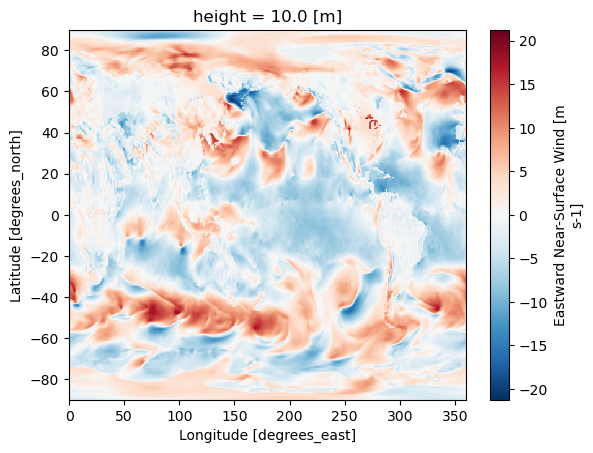

In [5]:
ds_source.uas.plot()

Now let's create our forcing perturbation. Here we will do a multiplicative perturbation where we simply multiply the zonal winds in the tropical Pacific region by a time-independent factor of 1.25.

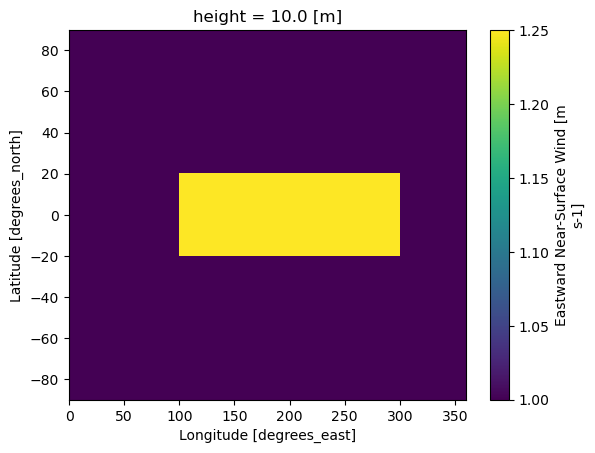

In [6]:
# Define 2D lon/lat:
lat2d,lon2d = xr.broadcast(ds_source.lat,ds_source.lon)

# Define the tropical Pacific region:
region = np.logical_and(np.logical_and(lon2d <= 300.,lon2d >= 100.),np.logical_and(lat2d >= -20.,lat2d <= 20.))

# Set the scaling factor:
ds_source['uas'].data = xr.where(region,1.25,1.)

# Write-out to file:
# ds_source.to_netcdf(out_file)

# Plot:
ds_source.uas.plot()

## Include the perturbation file in the simulation

To use this perturbation file, we need to make the following modifications to our configuration files.

Add the folder to the input folders list in `config.yaml` (note below "+" indicates added lines, "-" indicates lines taken away, don't include the "+"!):
```
...

            - /g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-4-0/landIce/day/licalvf/gr/v20190429
+           - /g/data/e14/rmh561/access-om2/forcing_perturbations/
...
```

Add the following to the `atmosphere/forcing.json` file in the `uas` section:

```
...
{
      "filename": "INPUT/uas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-4-0_gr_{{year}}01010000-{{year}}12312100.nc",
      "fieldname": "uas",
-     "cname": "uwnd_ai"
+     "cname": "uwnd_ai",
+      "perturbations": [
+        {
+          "type": "scaling",
+          "dimension": "spatial",
+          "value": "INPUT/uas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-4-0_gr_Tropical_Pacific_Perturbation.nc",
+          "calendar": "forcing",
+          "comment": "Time-independent increase in tropical Pacific zonal winds"
+        }
+       ]
    },
...
```

## Finally, run the simulation and analyse the results

```
cd $HOME/access-om2/1deg_jra55_iaf_perturbed
payu setup
payu sweep
payu run -n 2
```

Note; the `payu setup`, `payu sweep` above is not strictly neccessary. However, the `payu setup` step allows you to check that everything is setup and all the input files are linked properly before running the simulation. For example, after the `payu setup` command you can look inside `work`:

```
[rmh561@gadi-login-07 1deg_jra55_iaf_perturbed]$ ls -alh work/atmosphere/INPUT/
...
...
lrwxrwxrwx 1 rmh561 dx2  143 Mar 27 09:52 uas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-4-0_gr_Tropical_Pacific_Perturbation.nc -> /g/data/e14/rmh561/access-om2/forcing_perturbations/uas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-4-0_gr_Tropical_Pacific_Perturbation.nc
...
...
```
So the perturbation file is indeed in our list of inputs.

That's it. To confirm that everything worked, we look at the output (note; once the simulations was done I removed the link to `output001` of the control simulation in the perturbation output, using `rm archive/output001` so that it doesn't turn up in this analysis):

In [8]:
control_base = '/scratch/e14/rmh561/access-om2/archive/1deg_jra55_iaf/'
perturb_base = '/scratch/e14/rmh561/access-om2/archive/1deg_jra55_iaf_perturbed/'

In [9]:
# Plot global surface temperature:
ds_scalar_control = xr.open_mfdataset(glob.glob(control_base + 'output*/ocean/ocean-scalar*.nc'))
ds_scalar_perturb = xr.open_mfdataset(glob.glob(perturb_base + 'output*/ocean/ocean-scalar*.nc'))

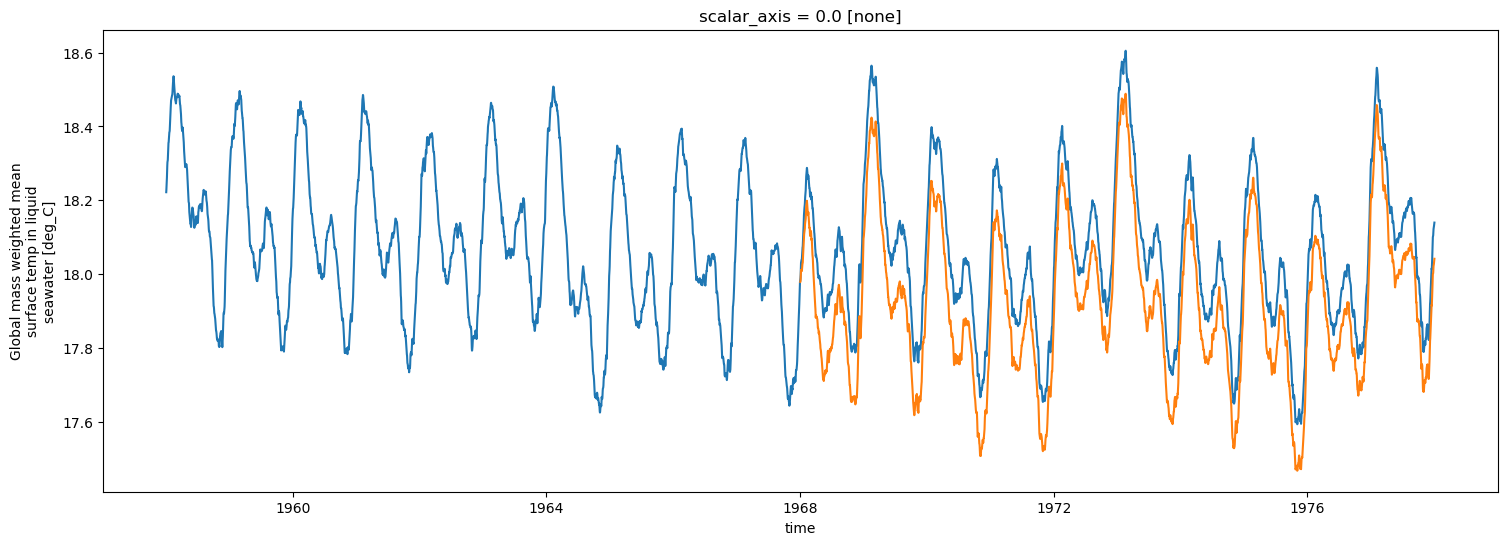

In [10]:
plt.figure(figsize=(18,6))
ds_scalar_control.temp_surface_ave.plot(label='Control')
ds_scalar_perturb.temp_surface_ave.plot(label='Perturbation')

In [11]:
# Plot SST maps and differences at different times:
SST_control = xr.open_mfdataset(glob.glob(control_base + 'output*/ocean/ocean-2d-surface_pot_temp-1-monthly-*.nc')).surface_pot_temp
SST_perturb = xr.open_mfdataset(glob.glob(perturb_base + 'output*/ocean/ocean-2d-surface_pot_temp-1-monthly-*.nc')).surface_pot_temp

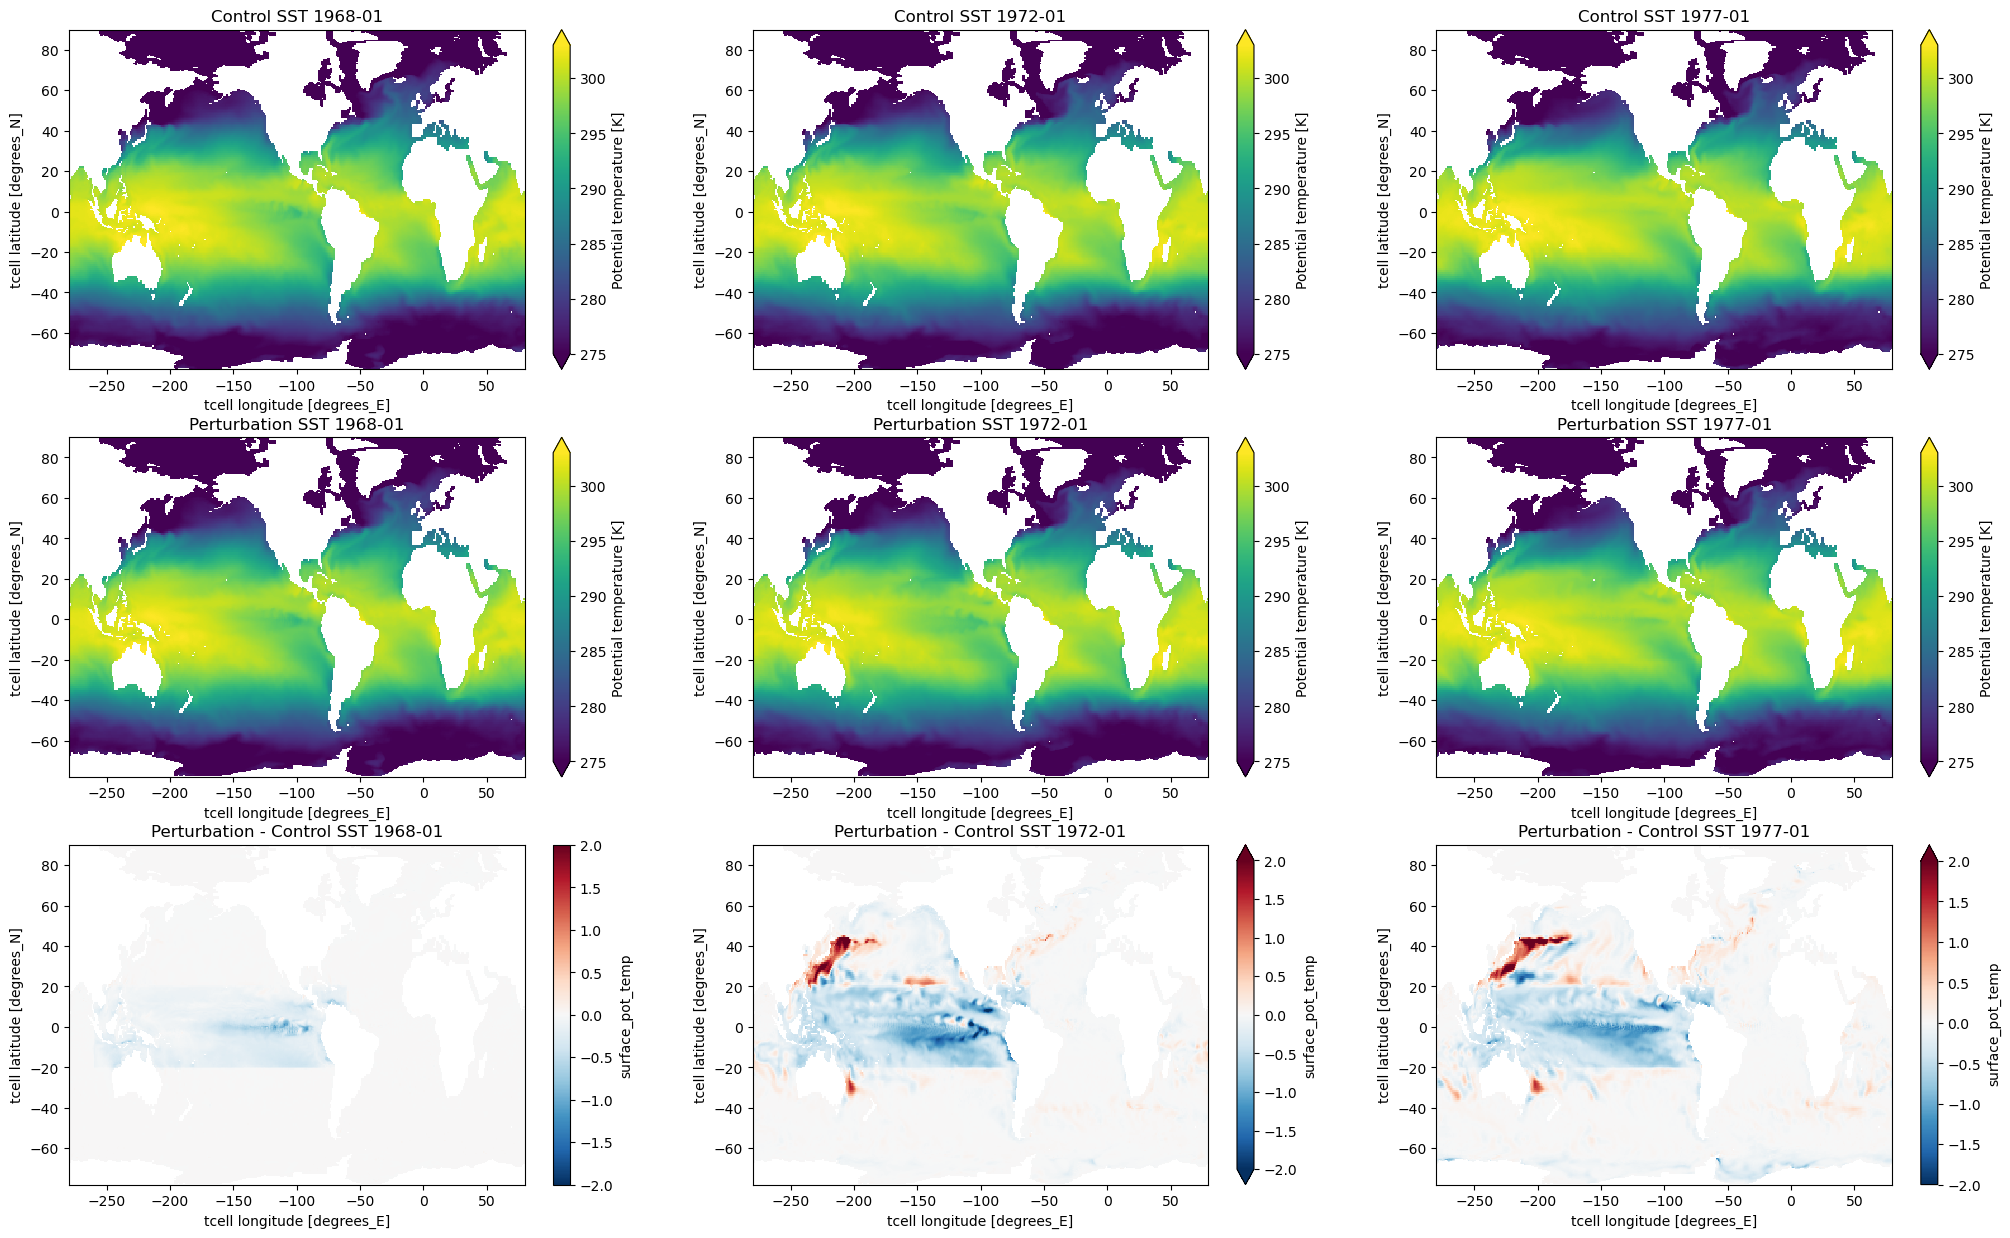

In [12]:
fig, axes = plt.subplots(nrows=3,ncols=3,figsize=(25,15))
time1 = np.datetime64('1968-01-16T12:00:00')
time2 = np.datetime64('1972-01-16T12:00:00')
time3 = np.datetime64('1977-01-16T12:00:00')

for i,time in enumerate([time1,time2,time3]):
    SST_control.sel(time=time).plot(ax=axes[0][i],vmin=275.,vmax=303)
    axes[0][i].set_title('Control SST ' + str(np.datetime64(time,'M')))
    SST_perturb.sel(time=time).plot(ax=axes[1][i],vmin=275.,vmax=303)
    axes[1][i].set_title('Perturbation SST ' + str(np.datetime64(time,'M')))
    (SST_perturb-SST_control).sel(time=time).plot(ax=axes[2][i],vmin=-2.,vmax=2.,cmap='RdBu_r')
    axes[2][i].set_title('Perturbation - Control SST ' + str(np.datetime64(time,'M')))
    

## Other perturbations

This is just a simple time-independent *multiplicative* perturbation.

There are many other perturbation types possible, including *additive* perturbations (use `"type": "offset"`), spatially-uniform time-dependent perturbations (use `"dimension": "temporal"`) or combinations of these (which are very useful as you can make a spatiotemporal perturbation without having to define a full $x\times y\times t$ perturbation file at JRA's 3-hourly time resolution). These just require generalizations of what we've done above (e.g. dropping all space dimensions for time-only-dependent perturbations etc.), see the tutorial: https://github.com/COSIMA/access-om2/wiki/Tutorials#Scaling-the-forcing-fields

If anyone has the inclination, it would be great to add some more sophisticated cases here for future reference. In particular, dealing with RYF vs. IAF and `"calendar": "forcing"` vs. `"calendar": "experiment"` needs to be described.